<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/hotel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

The data set is one I have sampled from a much larger data set of over 1 million hotel reviews from around the world. I have cleaned the text here, removing stop words and converting to all lower case. 

The original data set included several ratings, 1 to 5 stars, including cleanliness, service, location, etc., as well as an overall rating. I averaged those for each review and binned the results into binary sentiment: 0 bad, 1 good. The model then classifies reviews in that regard.

In [2]:
data_path = 'https://raw.githubusercontent.com/karencfisher/hotel-reviews/main/data/reviews_sample.csv'
df_reviews = pd.read_csv(data_path)
df_reviews.drop(columns=['Unnamed: 0', 'average_score'], inplace=True)

df_reviews.sample(10)

,Content,sentiment
5095,inexpensive awful traveled las vegas christmas...,0
2541,hotel horrid stay didnt stay saw rooms friends...,0
13640,3 words dump total nightmare room nightclub op...,0
27281,ok hotel good value stayed cq midtown sept 57 ...,1
5925,tiny hotel room minute double bedding clean br...,0
13492,overpriced yet grubby tons ok places stay madr...,0
16186,nothing fancy nice pool location pros easy con...,0
8704,23 february 2011 enjoyable stay stayed raglan ...,0
32585,great hotel nice hotel enjoyed stay therei lef...,1
10409,decent standing stayed two nights 3star hotel ...,0


Train test split

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df_reviews['Content'],
                                                    df_reviews['sentiment'],
                                                    test_size=0.1)
x_train.shape, y_test.shape

((31609,), (3513,))

Tokenizing the reviews. The tokenizer is trained on the training dataset only; it is applied to both. If there is an unknown word in the test data, it will be replaced with a special token '<OOV>' -- meaning "Out Of Vocabulary." We also limited the vocabularly to the top 10000 words. Other words will be renedered as '<OOV>'. They tend to be more rarely used words.

The tokenizer also converts the individual tokens to integers, which are indexes of the words in the vocabularly. 

The next step then is to pad the reviews so as to be of all the same length. This is because the input dimension to the neural network is of fixed length. The individual reviews are padded at the end to be of the same length as the longest review.


In [4]:
vocab_size = 10000
embed_dim = 64
oov_token = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
x_train_text = tokenizer.texts_to_sequences(x_train)
x_train_text = pad_sequences(x_train_text, padding='post')

x_test_text = tokenizer.texts_to_sequences(x_test)
x_test_text = pad_sequences(x_test_text, padding='post')


Here is an example of a review as it is topenized, as well as the text, with the out of vocabularly tokens, including padding.

In [7]:
x_train_text[2342]

array([ 747, 5672, 2199, ...,    0,    0,    0], dtype=int32)

In [8]:
tokenizer.sequences_to_texts([x_train_text[2342]])

['w winning attended conference month ago impressed hotel service first time w downtown san diego never thought stay ended talking one banquet servers michelle recommended bring girlfriend stay hotel great environment couples ended booking room loved every aspect hotel service comfy beds hotel clean contemporary service five star quality rooms extremely comfy beds keep coming back <OOV> recommendation greatly appreciated experience girlfriend definitely put w hotel top list next time need book room business pleasure <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV

Construct the Bidirectional LSTM network. The final classification is performed after the LSTM layer with a fully connected layer. It has the following layers:



1.   Embedding layer. Translates the tokens into word vectors (64 values).
2.   BiDirectional LSTM layer
3.   Hidden dense layer with 64 neurons and Relu activation function.
4    Output layer of single neuron with Sigmoid activation. It returns 0 to 1:
     If > .5 is a positive review, otherwise negative.





In [16]:
model = Sequential([Embedding(vocab_size, embed_dim, mask_zero=True),
                    Bidirectional(LSTM(embed_dim, dropout=0.20)),
                    Dense(64, activation='relu'),
                    Dense(1, activation='sigmoid')])

opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714,369
Trainable params: 714,369
Non-trainable params: 0
_________________________________________________________________


Train the model. 

In [17]:
stopping = EarlyStopping(monitor='val_accuracy', 
                         patience=3, 
                         restore_best_weights=True)

history = model.fit(x_train_text, 
                    y_train, 
                    epochs=30, 
                    validation_data=(x_test_text, y_test),
                    callbacks=[stopping])

Epoch 1/30
988/988 [==============================] - 54s 47ms/step - loss: 0.6918 - accuracy: 0.5597 - val_loss: 0.6895 - val_accuracy: 0.6553
Epoch 2/30
988/988 [==============================] - 43s 44ms/step - loss: 0.6699 - accuracy: 0.7296 - val_loss: 0.5573 - val_accuracy: 0.7965
Epoch 3/30
988/988 [==============================] - 43s 43ms/step - loss: 0.4652 - accuracy: 0.8221 - val_loss: 0.4344 - val_accuracy: 0.8360
Epoch 4/30
988/988 [==============================] - 43s 44ms/step - loss: 0.4166 - accuracy: 0.8455 - val_loss: 0.4151 - val_accuracy: 0.8426
Epoch 5/30
988/988 [==============================] - 43s 43ms/step - loss: 0.3938 - accuracy: 0.8526 - val_loss: 0.3982 - val_accuracy: 0.8412
Epoch 6/30
988/988 [==============================] - 44s 44ms/step - loss: 0.3754 - accuracy: 0.8603 - val_loss: 0.3857 - val_accuracy: 0.8503
Epoch 7/30
988/988 [==============================] - 43s 44ms/step - loss: 0.3603 - accuracy: 0.8660 - val_loss: 0.3752 - val_accuracy:

Model evaluation. 

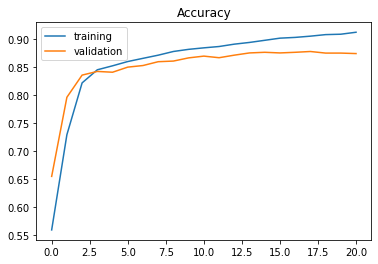

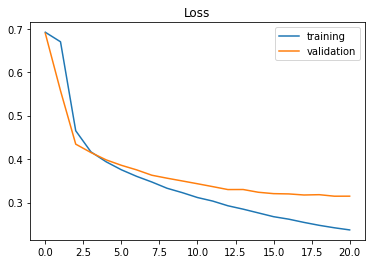

In [18]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label ='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label ='validation')
plt.legend()
plt.title('Loss')
plt.show()


In [19]:
pred_y = model.predict(x_test_text, verbose=1)
pred_y = pred_y > 0.5

110/110 [==============================] - 5s 22ms/step


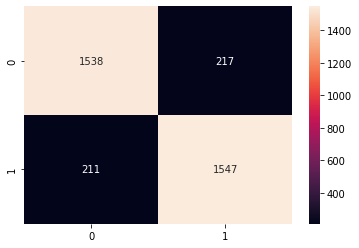

In [20]:
cf = confusion_matrix(pred_y, y_test)
sns.heatmap(cf, annot=True, fmt='d');

In [21]:
print(classification_report(pred_y, y_test, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      1755
    Positive       0.88      0.88      0.88      1758

    accuracy                           0.88      3513
   macro avg       0.88      0.88      0.88      3513
weighted avg       0.88      0.88      0.88      3513



Compare with baseline: the probability of being accurate if one randomly guesses one or zero for each example, which is 66.89%.